# Drifters module - demo

`pynsitu.drifters` implements methods useful to the cleaning and processing of drifter trajectories.

Drifter data is assumed to be contained within a pandas dataframe with with a least the following columns: time, longitude, latitude. 
A column may also described the drifter id.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pynsitu as pin

---

## generate synthetic drifter trajectories


In [2]:
def generate_one_trajectory(u_mean=0, v_mean=0, u_wave=0, noise=0, id=0):

    freq = "1H"

    time_unit = pd.Timedelta("1s")
    dt = pd.Timedelta(freq) / time_unit
    time = pd.date_range(start="2018-01-01", end="2018-02-01", freq=freq)
    _time = (time - time[0]) / time_unit

    lon0, lat0 = -20, 30
    scale_lat = 111e3
    scale_lon = scale_lat * np.cos(lat0 * pin.deg2rad)
    T = pd.Timedelta("1D") / time_unit

    u = (
        u_mean
        + u_wave * np.cos(2 * np.pi * _time / T)
        + np.random.randn(time.size) * noise
    )
    v = (
        v_mean
        + u_wave * np.sin(2 * np.pi * _time / T)
        + np.random.randn(time.size) * noise
    )

    lon = lon0 + np.cumsum(u) * dt / scale_lon
    lat = lat0 + np.cumsum(v) * dt / scale_lat
    # lon = u
    # lat = v

    df = pd.DataFrame(dict(lon=lon, lat=lat, time=time, u=u, v=v))
    df["id"] = id
    df = df.set_index("time")

    return df

In [3]:
# actually generate one time series
df = generate_one_trajectory(u_mean=-0.1, v_mean=0, u_wave=0.1, noise=0.05, id=0)
df.head()

,lon,lat,u,v,id
time,,,,,
2018-01-01 00:00:00,-19.996870,30.000955,0.083570,0.029453,0
2018-01-01 01:00:00,-19.997752,30.000301,-0.023556,-0.020184,0
2018-01-01 02:00:00,-19.998340,30.003080,-0.015683,0.085712,0
2018-01-01 03:00:00,-19.999521,30.004247,-0.031549,0.035957,0
2018-01-01 04:00:00,-20.007881,30.005355,-0.223213,0.034172,0


---

## basic plots to inspect data

May be useful to clean up drifter time series

In [4]:
df.geo.plot_bokeh()

Loading BokehJS ...

In [5]:
phv, coords = df.geo.plot_on_map()
phv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (time)

### compute velocities

Multiple methods are employed to compute velocities, see `compute_velocities` doc and code.
Some involve projecting data which results in local cartesian coordinates `x` and `y`.

In [6]:
df.geo.compute_velocities(inplace=True)
df.head()

,lon,lat,u,v,id,x,y,velocity_east,velocity_north,velocity
time,,,,,,,,,,
2018-01-01 00:00:00,-19.996870,30.000955,0.083570,0.029453,0,141596.336044,-272.770935,-0.031545,-0.125913,0.129804
2018-01-01 01:00:00,-19.997752,30.000301,-0.023556,-0.020184,0,141512.156849,-346.426912,-0.019692,0.032721,0.038189
2018-01-01 02:00:00,-19.998340,30.003080,-0.015683,0.085712,0,141451.548052,-38.997503,-0.023703,0.060754,0.065214
2018-01-01 03:00:00,-19.999521,30.004247,-0.031549,0.035957,0,141335.908276,88.818358,-0.127848,0.035022,0.132558
2018-01-01 04:00:00,-20.007881,30.005355,-0.223213,0.034172,0,140527.892619,201.388336,-0.126496,0.071096,0.145106


In [7]:
df.geo.plot_bokeh(velocity=True)

Loading BokehJS ...

In [8]:
phv, coords = df.geo.plot_on_map(s=10, c="velocity", clim=(0, 0.3), cmap="magma")
phv

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (velocity,time)

### compare different methods to compute velocities

In [9]:
df_sp = df.geo.compute_velocities(distance="spectral", inplace=False)
df_xy = df.geo.compute_velocities(distance="xy", inplace=False)

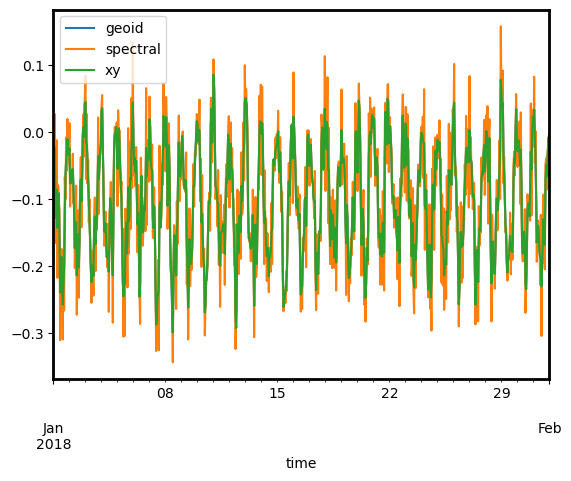

In [10]:
df["velocity_east"].plot(label="geoid")
df_sp["velocity_east"].plot(label="spectral")
df_xy["velocity_east"].plot(label="xy")
plt.legend()

In [11]:
kwargs = dict(include=["velocity_east"], nperseg=24 * 5, detrend=False)
E = df.ts.spectrum(**kwargs)
E_sp = df_sp.ts.spectrum(**kwargs)
E_xy = df_xy.ts.spectrum(**kwargs)

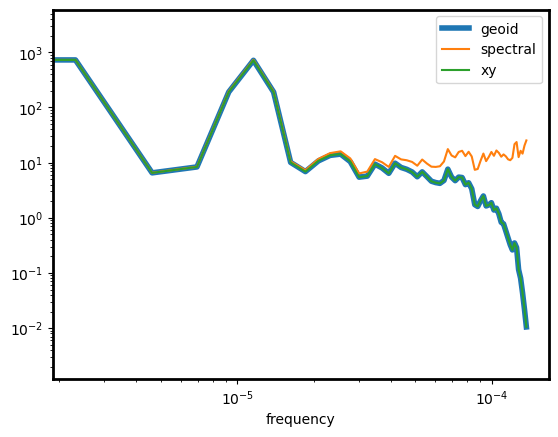

In [12]:
# spectrum comparison
ax = E["velocity_east"].rename("geoid").plot(lw=4)
E_sp["velocity_east"].rename("spectral").plot(ax=ax)
E_xy["velocity_east"].rename("xy").plot(ax=ax)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

---

## concatenate multiple trajectories and manipulate

In [13]:
ids = [0, 1, 2]
u_wave = [0, 0.1, 0.2]
dfm = (
    pd.concat(
        [
            generate_one_trajectory(u_mean=-0.1, v_mean=0, u_wave=uw, noise=0.05, id=id)
            for id, uw in zip(ids, u_wave)
        ]
    )
    .reset_index()
    .set_index("id")
)

# get all drifter ids
ids = list(dfm.index.unique())

dfm.head()

,time,lon,lat,u,v
id,,,,,
0,2018-01-01 00:00:00,-20.005316,29.998648,-0.141937,-0.041690
0,2018-01-01 01:00:00,-20.007592,29.998725,-0.060789,0.002381
0,2018-01-01 02:00:00,-20.012756,30.000729,-0.137882,0.061799
0,2018-01-01 03:00:00,-20.013603,30.002283,-0.022621,0.047900
0,2018-01-01 04:00:00,-20.017829,30.001386,-0.112852,-0.027658


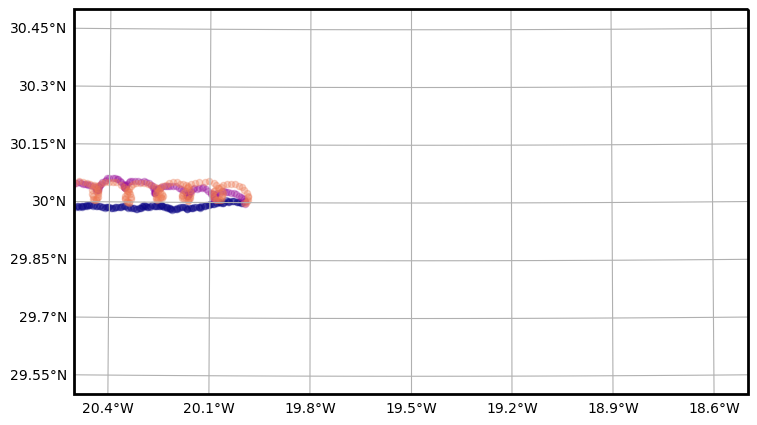

In [14]:
fig, ax, _ = pin.maps.plot_map(extent=[-20.5, -18.5, 29.5, 30.5])

colors = pin.get_cmap_colors(len(ids))

for i, c in zip(ids, colors):
    dfm.loc[i].plot.scatter(
        ax=ax, x="lon", y="lat", c=c, alpha=0.3, transform=pin.maps.crs
    )

Compute velocities and averaged energy per drifter

In [15]:
dfm_vel = (
    dfm.groupby("id")
    .apply(lambda df: df.set_index("time").geo.compute_velocities().reset_index())
    .droplevel(1)
)

<Axes: xlabel='id'>

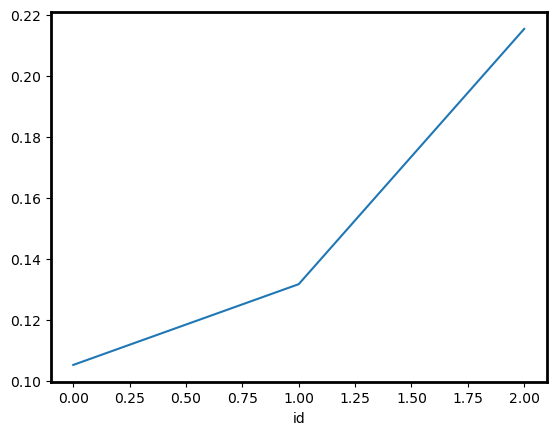

In [16]:
dfm_vel.groupby("id")["velocity"].mean().plot()

---

## compute window averaged diagnostics (spectra, autocorrelations)

In [17]:
...

Ellipsis

---

## denoise/despike time series

In [18]:
...

Ellipsis